# RNA-ATAC Vertical Integration (Mouse Embryo E11.0)

Config

In [24]:
import os
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import argparse
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from SpaMode.utils import clustering
from SpaMode.preprocess import clr_normalize_each_cell, pca
from SpaMode.preprocess import fix_seed

fix_seed(2024)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import json
with open("config/cfg_training.json", "r") as file:
    config = json.load(file)
    cfg = config["MISAR"]["E11_0"]
print(cfg)

{'RNA_Path': '/home/hxl/Spa_Multi-omics/Data/Datasets/MISAR/S1/E11/MISAR_E11_0-S1_RNA.h5ad', 'ADT_Path': '', 'ATAC_Path': '/home/hxl/Spa_Multi-omics/Data/Datasets/MISAR/S1/E11/MISAR_E11_0-S1_ATAC.h5ad', 'GT_path': '/home/hxl/Spa_Multi-omics/Data/Datasets/MISAR/S1/E11/MISAR_Combined_E11_0_S1_GT.txt', 'training_epoch': 1000, 'learning_rate': 0.0005, 'weight_decay': 0, 'weight_recon': [1.0, 1.0], 'weight_bi': 1, 'weight_adv': 0.1, 'weight_kl': 1e-06, 'weight_moe': 100.0, 'optimizer': 'SGD', 'earlystop': True, 'early_stop_patience': 20}


*Data preprocess*

In [27]:
print('Loading Data...')

def TFIDF(count_mat, type_=2):
    # Perform TF-IDF (count_mat: peak*cell)
    def tfidf1(count_mat):
        if not scipy.sparse.issparse(count_mat):
            count_mat = scipy.sparse.coo_matrix(count_mat)

        nfreqs = count_mat.multiply(1.0 / count_mat.sum(axis=0))
        tfidf_mat = nfreqs.multiply(np.log(1 + 1.0 * count_mat.shape[1] / count_mat.sum(axis=1)).reshape(-1, 1)).tocoo()

        return tfidf_mat.toarray()

    # Perform Signac TF-IDF (count_mat: peak*cell) [default selected]
    def tfidf2(count_mat):
        if not scipy.sparse.issparse(count_mat):
            count_mat = scipy.sparse.coo_matrix(count_mat)

        tf_mat = count_mat.multiply(1.0 / count_mat.sum(axis=0))
        signac_mat = (1e4 * tf_mat).multiply(1.0 * count_mat.shape[1] / count_mat.sum(axis=1).reshape(-1, 1))
        signac_mat = signac_mat.log1p()

        return signac_mat.toarray()

    # Perform TF-IDF (count_mat: ?)
    from sklearn.feature_extraction.text import TfidfTransformer
    def tfidf3(count_mat):
        model = TfidfTransformer(smooth_idf=False, norm="l2")
        model = model.fit(np.transpose(count_mat))
        model.idf_ -= 1
        tf_idf = np.transpose(model.transform(np.transpose(count_mat)))

        return tf_idf.toarray()

    if type_ == 1:
        return tfidf1(count_mat)
    elif type_ == 2:
        return tfidf2(count_mat)
    else:
        return tfidf3(count_mat)

adata_omics_list = []
if cfg['RNA_Path'] != '':
    adata_omics1 = sc.read_h5ad(cfg['RNA_Path'])
    adata_omics1.var_names_make_unique()
    sc.pp.filter_genes(adata_omics1, min_cells=10)
    sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata_omics1, target_sum=1e4)
    sc.pp.log1p(adata_omics1)
    sc.pp.scale(adata_omics1)
    adata_omics1_high = adata_omics1[:, adata_omics1.var['highly_variable']]
    adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=30)
    adata_omics_list.append(adata_omics1)
    print('RNA Feat:')
    print(adata_omics1)
if cfg['ATAC_Path'] != '':
    adata_omics3 = sc.read_h5ad(cfg['ATAC_Path'])
    adata_omics3.var_names_make_unique()
    adata_omics3 = adata_omics3[
        adata_omics1.obs_names].copy()  # .obsm['X_lsi'] represents the dimension reduced feature
    adata_omics3.X = TFIDF(adata_omics3.X.T).T.copy()
    adata_omics3.obsm['feat'] = pca(adata_omics3, n_comps=50)
    adata_omics_list.append(adata_omics3)
    print('ATAC Feat:')
    print(adata_omics3)

Loading Data...


/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


RNA Feat:
AnnData object with n_obs × n_vars = 1263 × 15537
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'ATAC_Clusters', 'Combined_Clusters', 'RNA_Clusters', 'spatial', 'feat'
ATAC Feat:
AnnData object with n_obs × n_vars = 1263 × 69370
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'ATAC_Clusters', 'Combined_Clusters', 'RNA_Clusters', 'spatial', 'feat'


*Construct graph*

In [28]:
from SpaMode.preprocess import construct_neighbor_graph_SpaMode
data = construct_neighbor_graph_SpaMode(adata_omics_list, datatype='MISAR',
                                     Spatial_neighbors=3, Feature_neighbors=20)

Spatial_neighbors = 3
Feature_neighbors = 20


*Define SpaMode*

In [29]:
from SpaMode.Train import Train_SpaMode
model = Train_SpaMode(data, datatype='MISAR', device=device, Arg=cfg)

tensor([0.4570, 0.5430], device='cuda:0')


/home/hxl/Spa_Multi-omics/SpaMode/SpaMode/Train.py:285: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weight = F.softmax(differ_stack)


*Training SpaMode*

In [30]:
output = model.train()

optimizer:  SGD


  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▎      | 325/1000 [00:08<00:17, 38.16it/s, Biloss=0.248, adv_loss=0.282, kl_loss=0.254, moe_loss=0.0328, recon=35.1]  

Early Stop
Model training finished!



*clustering*

In [31]:
adata = adata_omics1.copy()
adata.obsm['SpaMode'] = output['SpaMode'].copy()
tool = 'mclust'  # mclust, leiden, and louvain
n_clusters=4
print('n_clusters:', n_clusters)
clustering(adata, key='SpaMode', add_key='SpaMode', n_clusters=n_clusters, method=tool, use_pca=True)
label_list = adata.obs['SpaMode'].tolist()
adata.obs['Our_label'] = np.array(label_list).astype(str)
adata.obs['Our_label'] = adata.obs['Our_label'].astype('category')

n_clusters: 4
fitting ...
  |======================================================================| 100%


*Visualization*

/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


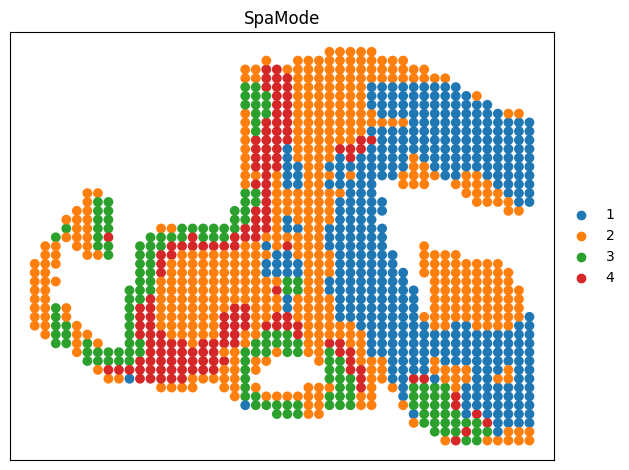

In [32]:
fig = sc.pl.embedding(adata, basis='spatial', color='Our_label', title='SpaMode', s=200, show=False, return_fig=True)

ax = fig.axes[0]
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout(w_pad=0.3)
plt.show()

*SR*

In [33]:
from Spatial_rectify import Label_smoothing
label_list_SR = Label_smoothing(adata_omics1, label_list, n_neighbors=4, threshold=2)

Corrected labels total num 54
Corrected labels total num 14
Corrected labels total num 6
Corrected labels total num 1
Corrected labels total num 0


*Visualization SR*

/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


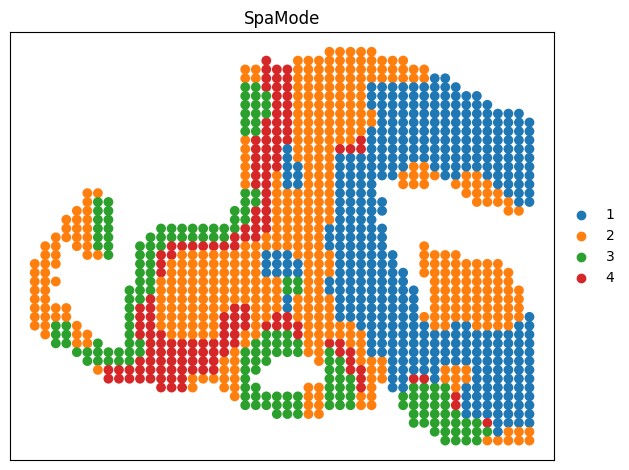

In [34]:
adata.obs['Our_label'] = np.array(label_list_SR).astype(str)
adata.obs['Our_label'] = adata.obs['Our_label'].astype('category')
fig = sc.pl.embedding(adata, basis='spatial', color='Our_label', title='SpaMode', s=200, show=False, return_fig=True)
ax = fig.axes[0]
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout(w_pad=0.3)
plt.show()

*Metrics*

In [35]:
from cal_matrics import eval
txt_out_path = '/home/hxl/Spa_Multi-omics/SpaMode/Results/MISAR/SpaMode_E15_5.txt'
eval_save_path = '/home/hxl/Spa_Multi-omics/SpaMode/Results/MISAR/SpaMode_E15_5_metrics.txt'

with open(txt_out_path, 'w') as f:
    for num in label_list_SR:
        f.write(f"{num}\n")
        
eval(cfg['GT_path'], txt_out_path, eval_save_path)

1 8
1 4
{1, 2, 3, 4, 5, 6, 7, 8}
1263
1263
our         jaccard: 0.598982
our         F_measure: 0.749204
our         Mutual Information: 0.826842
Our         (NMI): 0.607462
Our         (AMI): 0.604966
Our         V-measure: 0.607462
Our         Homogeneity: 0.570163 Completeness: 0.649983
Our         (ARI): 0.646928
Our         (FMI): 0.750140
